## Research question
Does a person's genotype influence their risk of developing cardiovascular disease (CVD)?

## 1. Dataset overview
You have access to data from a long-term study of 50,000 Estonian individuals who have been observed since birth. Each person was screened to determine whether or not they developed CVD during their lifetime. All individuals have also been genotyped for a genetic variant (genotype) associated with CVD risk. The goal is to investigate how this genotype influences the age at onset of CVD. The data also includes information about each person’s sex and body mass index.

This is a survival dataset, meaning it includes follow-up time for each individual, captured by the "age" variable. Some individuals experienced the event of interest (CVD), while others were censored, i.e. they died without ever having the disease during the observation period.

### The dataset contains the following five variables:
1.	Age – the person’s age in years at the time of CVD diagnosis (if they had it), or age at death (if they did not)

2.	Event – indicates whether the person experienced a CVD event:

* 1: the person had CVD
* 0: the person did not have CVD and died from another cause

3.	Genotype – the number of risk alleles a person has; it can be:
* 0: no risk alleles (e.g., genotype "AA")
* 1: one risk allele (e.g., "Aa")
* 2: two risk alleles (e.g., "aa")
Note: The genotype is located on an autosomal chromosome, meaning it is not associated with biological sex. 

4.	BMI – body mass index (kg/m2)

5.	Sex – the biological sex of the individual

In [1]:
import pandas as pd
df = pd.read_csv('CVD_data.csv').sample(2000) # Tarmo: let's take a sample of n=2000 here to avoid running into memory issues and make model run a little faster

df.head()

,age,event,genotype,bmi,sex
11793,89,0,0,20.896750,male
39707,74,0,0,24.906636,male
8987,89,0,0,25.243968,male
14638,68,0,0,20.964754,female
41253,77,0,0,22.750228,male


## 2. Method & DAG

We are going to model the age, when the CVD is theoretically diagnosed, assuming infinite life span and that *almost surely* everyone will be diagnosed with CVD eventually. To model the age at CVD diagnosis, we use the Weibull distribution, which is parameterised by **shape** $\alpha$ and **scale** $\beta$. Weibull distribution is commonly used in survival analysis, as hazard rate is proportional to a power of time:
$$
    \frac{\alpha}{\beta}\left(\frac{t}{\beta}\right)^{\alpha-1}.
$$
This is useful, because for $\alpha>1$, it models aging process, where person is more likely to be diagnosed as time goes on.


### DAG
Below we present DAG with the least amount of assumed independencies. Note that the **Age at Death** is assumed to be before being diagnosed **CVD** and therefore we can assume that given all the common causes of **CVD** and **Death**, they are independent.

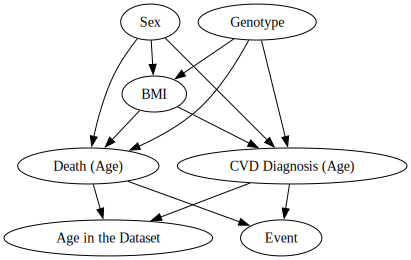

In [25]:
from graphviz import Digraph

dot = Digraph()

# Nodes
dot.node('G', 'Genotype')
dot.node('B', 'BMI')
dot.node('S', 'Sex')
dot.node('T', 'Death (Age)')
dot.node('C', 'CVD Diagnosis (Age)')
dot.node('D', 'Age in the Dataset')
dot.node('E', 'Event')

# Edges
dot.edge('G', 'B')
dot.edge('S', 'B')
dot.edge('G', 'T')
dot.edge('S', 'T')
dot.edge('B', 'T')
dot.edge('G', 'C')
dot.edge('B', 'C')
dot.edge('S', 'C')
dot.edge('T', 'D')
dot.edge('C', 'D')
dot.edge('T', 'E')
dot.edge('C', 'E')

dot

## 3. Model Specification

We use a Weibull survival model with right–censoring ([Weibull proportional hazards model](https://en.wikipedia.org/wiki/Proportional_hazards_model#Specifying_the_baseline_hazard_function)).  Let

$$
T_i \;\sim\; \mathrm{Weibull}(\alpha,\;\beta_i),
$$

where $\alpha>0$ is the shape parameter and $\beta_i>0$ is the scale parameter for individual $i$.

### 3.1 Priors

We model the scale via a log‐linear regression:

$$
\eta_i = \text{intercept}
      + \beta_{\rm geno}\,\mathrm{geno}_i
      + \beta_{\rm bmi}\,\mathrm{bmi\_z}_i
      + \beta_{\rm sex}\,\mathrm{sex}_i,
\qquad
\beta_i = e^{\eta_i}.
$$

We place priors

$$
\begin{aligned}
\text{intercept}   &\sim \mathcal{N}\bigl(\mu_{\ln t},\,1\bigr),\quad
  \mu_{\ln t} = \frac1n\sum_{i=1}^n \ln t_{{\rm obs},i},\\
\beta_{\rm geno}   &\sim \mathcal{N}(0,\,1),\quad
\beta_{\rm bmi}    \sim \mathcal{N}(0,\,1),\quad
\beta_{\rm sex}    \sim \mathcal{N}(0,\,1),\\
\alpha             &\sim \mathrm{Gamma}(2,\,0.1).
\end{aligned}
$$

### 3.2 Censoring Likelihood

For each $i$ we have either
$$
T_i = t_{{\rm obs},i}\quad(\text{event observed})
\quad\text{or}\quad
T_i \ge t_{{\rm obs},i}\quad(\text{right‐censored}).
$$

Some notes.
* With the current model we assume that β_geno = β_Aa = β_aa / 2. We tested the model without this assumption and the posterior was  β_Aa ≈ β_aa / 2. So it's okay to assume it.
* We checked the distribution of genotypes in the sample (AA, Aa, aa)=(40469, 9016, 515) and it matches the Hardy-Weinberg equilibrium (40459, 9037, 505).

## 4. Bayesian model (Direct effect)

To measure direct effect of **Genotype** on **CVD Diagnosis** we have to block the path **Genotype $\rightarrow$ BMI $\rightarrow$ CVD Diagnosis**. As we controlled for **BMI** we created a path **Genotype $\rightarrow$ Sex $\rightarrow$ CVD Diagnosis**. This means we have to control for **Sex** as well.

Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, β_geno, β_bmi, β_sex, shape]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.


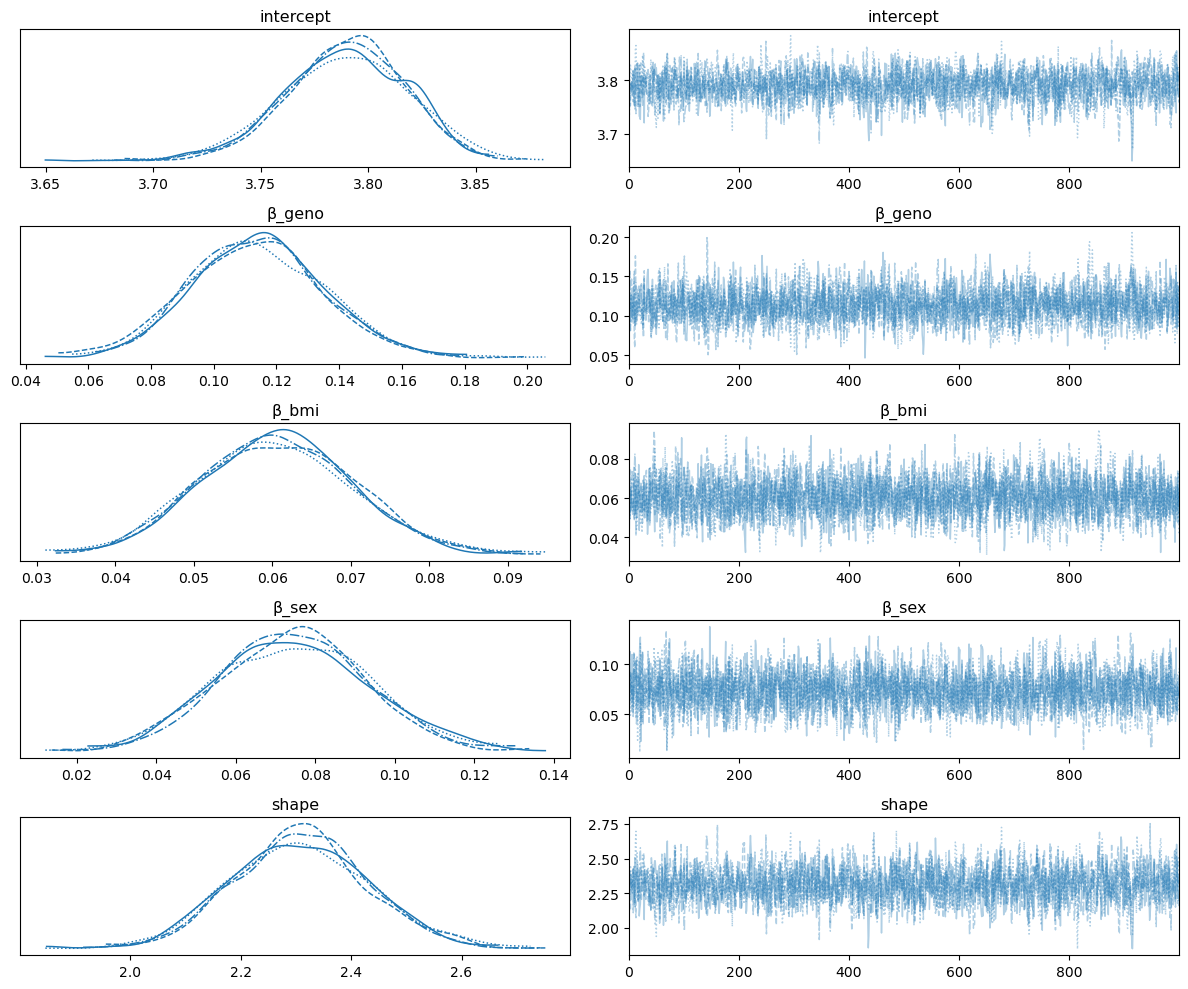

            mean     sd  hdi_3%  hdi_97%
intercept  3.789  0.028   3.737    3.841
β_geno     0.114  0.021   0.077    0.156
β_bmi      0.061  0.010   0.043    0.079
β_sex      0.074  0.019   0.039    0.109
shape      2.308  0.124   2.077    2.537


In [13]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

# 1) Load & preprocess
df = pd.read_csv("CVD_data.csv").sample(5000, random_state=42)

# Standardize BMI 
df["bmi_z"] = (df["bmi"] - df["bmi"].mean()) / df["bmi"].std()

# Observed time & censoring indicator
t_obs   = df["age"].values
# event=1 means CVD happened ⇒ uncensored; event=0 ⇒ right‐censored
censored = (df["event"] == 0).values  

# Covariates
geno   = df["genotype"].values
bmi_z  = df["bmi_z"].values
sex    = (df["sex"] == "male").astype(int).values

with pm.Model() as survival_model:
    # 2) Priors
    intercept   = pm.Normal("intercept", mu=np.log(t_obs).mean(), sigma=1)
    β_geno      = pm.Normal("β_geno",  mu=0, sigma=1)
    β_bmi       = pm.Normal("β_bmi",   mu=0, sigma=1)
    β_sex       = pm.Normal("β_sex",   mu=0, sigma=1)
    shape       = pm.Gamma("shape",    alpha=2, beta=0.1)

    # 3) Linear predictor → Weibull scale
    η     = intercept + β_geno * geno + β_bmi * bmi_z + β_sex * sex
    scale = pm.math.exp(η)

    # 4) Base Weibull distribution
    base_weib = pm.Weibull.dist(alpha=shape, beta=scale)

    # 5) For uncensored obs: T = t_obs  (so upper = t_obs, lower = -∞)
    #    For right‐censored: T ≥ t_obs ( so lower = t_obs, upper = +∞ )
    lower = np.where(censored, t_obs, -np.inf)
    upper = np.where(censored, np.inf,    t_obs)

    # 6) Censored likelihood
    pm.Censored(
        "survival", 
        base_weib,
        lower=lower,
        upper=upper,
        observed=t_obs
    )

    # 7) Inference
    idata = pm.sample(
        draws=1000,
        tune=1000,
        target_accept=0.9,
        init="adapt_diag",
        return_inferencedata=True,
        progressbar=False
    )
    # pm.sample_posterior_predictive(idata, var_names=["β_geno"], progressbar=False)

# 8) Diagnostics
az.plot_trace(idata, var_names=["intercept","β_geno","β_bmi","β_sex","shape"])
plt.tight_layout()
plt.show()

print(az.summary(idata, kind="stats", var_names=["intercept","β_geno","β_bmi","β_sex","shape"]))

As we can see, the β_geno is greater than 0 with probability close to 1. Hence genotypes **Aa** and **aa** increase the scale parameter of Weibull distribution, i.e. distribution spreads more out, i.e. CVD is more likely to be diagnosed at older age.

In [14]:
# What is the probability that β_geno > 0?
print(np.mean(idata.posterior["β_geno"] > 0))

<xarray.DataArray 'β_geno' ()> Size: 8B
array(1.)


## 5.Bayesian model (Global effect)

To measure global effect of **Genotype** on **CVD Diagnosis** there is no need to control for variables.

Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, β_geno, shape]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


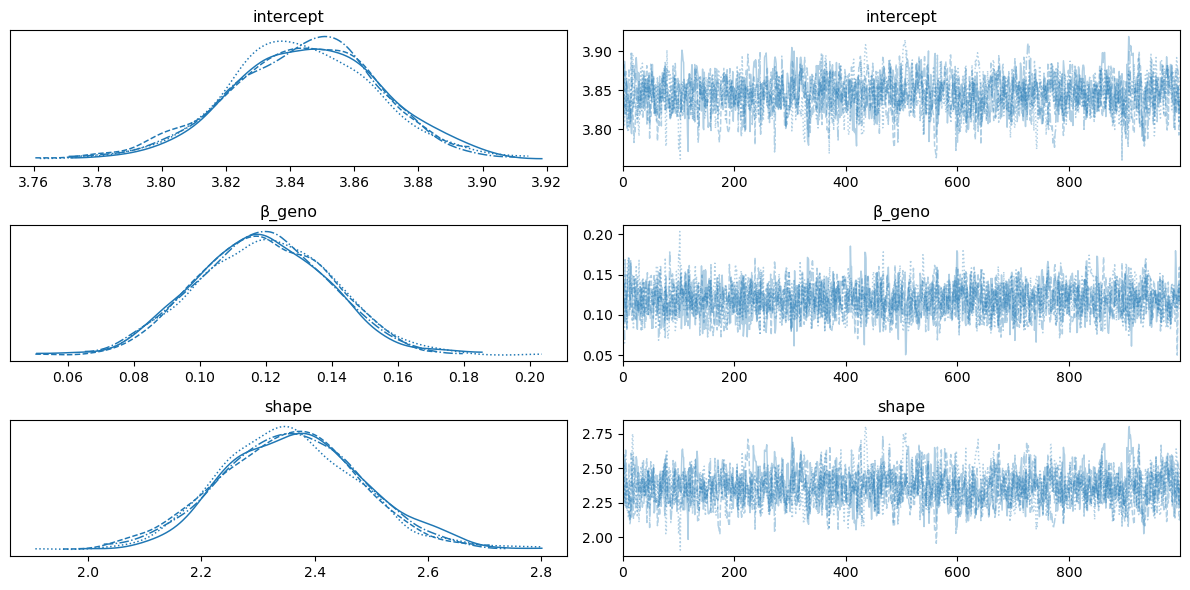

            mean     sd  hdi_3%  hdi_97%
intercept  3.844  0.023   3.801    3.889
β_geno     0.119  0.020   0.081    0.153
shape      2.360  0.123   2.128    2.591


In [15]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

# 1) Load & preprocess
df = pd.read_csv("CVD_data.csv").sample(5000, random_state=42)

# Standardize BMI 
df["bmi_z"] = (df["bmi"] - df["bmi"].mean()) / df["bmi"].std()

# Observed time & censoring indicator
t_obs   = df["age"].values
# event=1 means CVD happened ⇒ uncensored; event=0 ⇒ right‐censored
censored = (df["event"] == 0).values  

# Covariates
geno   = df["genotype"].values
bmi_z  = df["bmi_z"].values
sex    = (df["sex"] == "male").astype(int).values

with pm.Model() as survival_model:
    # 2) Priors
    intercept   = pm.Normal("intercept", mu=np.log(t_obs).mean(), sigma=1)
    β_geno      = pm.Normal("β_geno",  mu=0, sigma=1)
    shape       = pm.Gamma("shape",    alpha=2, beta=0.1)

    # 3) Linear predictor → Weibull scale
    η     = intercept + β_geno * geno
    scale = pm.math.exp(η)

    # 4) Base Weibull distribution
    base_weib = pm.Weibull.dist(alpha=shape, beta=scale)

    # 5) For uncensored obs: T = t_obs  (so upper = t_obs, lower = -∞)
    #    For right‐censored: T ≥ t_obs ( so lower = t_obs, upper = +∞ )
    lower = np.where(censored, t_obs, -np.inf)
    upper = np.where(censored, np.inf,    t_obs)

    # 6) Censored likelihood
    pm.Censored(
        "survival", 
        base_weib,
        lower=lower,
        upper=upper,
        observed=t_obs
    )

    # 7) Inference
    idata = pm.sample(
        draws=1000,
        tune=1000,
        target_accept=0.9,
        init="adapt_diag",
        return_inferencedata=True,
        progressbar=False
    )

# 8) Diagnostics
az.plot_trace(idata, var_names=["intercept","β_geno","shape"])
plt.tight_layout()
plt.show()

print(az.summary(idata, kind="stats", var_names=["intercept","β_geno","shape"]))

## Conclusion
Evidence suggests that the risk allele **a** decreases the chance of developing a CVD. 